In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.contrib.tensorboard.plugins import projector

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

num_epoch = 100
batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../../datasets/shapes_images.npy" )
data = np.load( "../../datasets/mnist-2-digit-images.npy" )

x_tr = data[:9000,in_timesteps]
y_tr = data[:9000,out_timesteps]

x_te = data[9000:,in_timesteps]
y_te = data[9000:,out_timesteps]

tr_set = data[0:9000, :, :, :]
te_set = data[9000:, :, :, :]

print np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te)

(9000, 19, 64, 64, 1) (9000, 19, 64, 64, 1) (11000, 19, 64, 64, 1) (11000, 19, 64, 64, 1)


In [2]:
lstm_units = 1024
feature_vector = 1024
latent_dim = 256

# placeholders to hold each frame
x_ = tf.placeholder("float", shape= (None, len(in_timesteps),  64, 64, 3))
y_ = tf.placeholder("float", shape= (None, len(out_timesteps), 64, 64, 3))

# encoder
encoder_conv1_w = tf.get_variable("encoder_conv1_w", shape=[7, 7, 3, 16])
encoder_conv2_w = tf.get_variable("encoder_conv2_w", shape=[5, 5, 16, 32])
encoder_conv3_w = tf.get_variable("encoder_conv3_w", shape=[5, 5, 32, 48])
encoder_conv4_w = tf.get_variable("encoder_conv4_w", shape=[3, 3, 48, 64])

encoder_conv1_b = tf.get_variable("encoder_conv1_b", shape=[16])
encoder_conv2_b = tf.get_variable("encoder_conv2_b", shape=[32])
encoder_conv3_b = tf.get_variable("encoder_conv3_b", shape=[48])
encoder_conv4_b = tf.get_variable("encoder_conv4_b", shape=[64])

def encoder(x):
    out = tf.nn.conv2d(input=x,   filter=encoder_conv1_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv2_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv3_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv4_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv4_b
    out = tf.nn.relu(out)
    out = tf.reshape(out, shape=[-1, 4*4*64])
    return out

# decoder
decoder_conv1_w = tf.get_variable("decoder_conv1_w", shape=[3, 3, 48, 64])
decoder_conv2_w = tf.get_variable("decoder_conv2_w", shape=[5, 5, 32, 48])
decoder_conv3_w = tf.get_variable("decoder_conv3_w", shape=[5, 5, 16, 32])
decoder_conv4_w = tf.get_variable("decoder_conv4_w", shape=[7, 7, 3, 16])

decoder_conv1_b = tf.get_variable("decoder_conv1_b", shape=[48])
decoder_conv2_b = tf.get_variable("decoder_conv2_b", shape=[32])
decoder_conv3_b = tf.get_variable("decoder_conv3_b", shape=[16])
decoder_conv4_b = tf.get_variable("decoder_conv4_b", shape=[3])

def decoder(x):
    out = tf.reshape(x, shape=[-1, 4, 4, 64])
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv1_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 8, 8, 48], padding='SAME') + decoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv2_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 16, 16, 32], padding='SAME') + decoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv3_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 32, 32, 16], padding='SAME') + decoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv4_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 64, 64, 3], padding='SAME') + decoder_conv4_b
    out = tf.nn.sigmoid(out)
    return out

# phi_enc
phi_enc_fc1_w = tf.get_variable("phi_enc_fc1_w", shape=[feature_vector+lstm_units, latent_dim])
phi_enc_fc2_w = tf.get_variable("phi_enc_fc2_w", shape=[latent_dim, latent_dim])

phi_enc_fc1_b = tf.get_variable("phi_enc_fc1_b", shape=[latent_dim])
phi_enc_fc2_b = tf.get_variable("phi_enc_fc2_b", shape=[latent_dim])

phi_enc_mu_w = tf.get_variable("phi_enc_mu_w", shape=[latent_dim, latent_dim])
phi_enc_mu_b = tf.get_variable("phi_enc_mu_b", shape=[latent_dim])

phi_enc_sigma_w = tf.get_variable("phi_enc_sigma_w", shape=[latent_dim, latent_dim])
phi_enc_sigma_b = tf.get_variable("phi_enc_sigma_b", shape=[latent_dim])

def phi_enc(out):
    out = tf.matmul(out, phi_enc_fc1_w) + phi_enc_fc1_b    
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_enc_fc2_w) + phi_enc_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, phi_enc_mu_w)  + phi_enc_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, phi_enc_sigma_w) + phi_enc_sigma_b)
    
    return out_mu, out_std

# phi_decoder
phi_dec_fc1_w = tf.get_variable("phi_dec_fc1_w", shape=[latent_dim+lstm_units, feature_vector])
phi_dec_fc2_w = tf.get_variable("phi_dec_fc2_w", shape=[feature_vector, feature_vector])

phi_dec_fc1_b = tf.get_variable("phi_dec_fc1_b", shape=[feature_vector])
phi_dec_fc2_b = tf.get_variable("phi_dec_fc2_b", shape=[feature_vector])

def phi_dec(out):
    out = tf.matmul(out, phi_dec_fc1_w) + phi_dec_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_dec_fc2_w) + phi_dec_fc2_b
    out = tf.nn.relu(out)
        
    return out

# phi_z
phi_z_fc1_w = tf.get_variable("phi_z_fc1_w", shape=[latent_dim, latent_dim])
phi_z_fc2_w = tf.get_variable("phi_z_fc2_w", shape=[latent_dim, latent_dim])

phi_z_fc1_b = tf.get_variable("phi_z_fc1_b", shape=[latent_dim])
phi_z_fc2_b = tf.get_variable("phi_z_fc2_b", shape=[latent_dim])

def phi_z(out):
    out = tf.matmul(out, phi_z_fc1_w) + phi_z_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_z_fc2_w) + phi_z_fc2_b
    out = tf.nn.relu(out)
    return out

# phi_prior
phi_prior_fc1_w = tf.get_variable("phi_prior_fc1_w", shape=[lstm_units, latent_dim])
phi_prior_fc2_w = tf.get_variable("phi_prior_fc2_w", shape=[latent_dim, latent_dim])

phi_prior_fc1_b = tf.get_variable("phi_prior_fc1_b", shape=[latent_dim])
phi_prior_fc2_b = tf.get_variable("phi_prior_fc2_b", shape=[latent_dim])

phi_prior_mu_w = tf.get_variable("phi_prior_mu_w", shape=[latent_dim, latent_dim])
phi_prior_std_w = tf.get_variable("phi_prior_std_w", shape=[latent_dim, latent_dim])

phi_prior_mu_b = tf.get_variable("phi_prior_mu_b", shape=[latent_dim])
phi_prior_std_b = tf.get_variable("phi_prior_std_b", shape=[latent_dim])

def phi_prior(out):
    out = tf.matmul(out, phi_prior_fc1_w) + phi_prior_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, phi_prior_fc2_w) + phi_prior_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, phi_prior_mu_w)  + phi_prior_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, phi_prior_std_w) + phi_prior_std_b)
    
    return out_mu, out_std

def tf_kl_gaussgauss(mu_1, sigma_1, mu_2, sigma_2):
    return tf.reduce_sum(tf.log(sigma_2) - tf.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*((sigma_2)**2)) - 0.5, axis=1)

def tf_kl_gaussgauss2(mu_1, sigma_1, mu_2, sigma_2):
    return tf.reduce_mean(tf.log(sigma_2) - tf.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*((sigma_2)**2)) - 0.5, axis=0)

def cross_entropy(y_prediction, y):
    prediction_loss = y * tf.log(1e-10 + y_prediction) + (1 - y) * tf.log(1e-10 + 1 - y_prediction)
    return -tf.reduce_sum(prediction_loss, axis=[1, 2, 3])   

def batch_data(source, target, batch_size):

   # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(target)))
    source = source[shuffle_indices]
    target = target[shuffle_indices]

    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]

        yield np.array(source_batch), np.array(target_batch)

# lstm
lstm  = tf.nn.rnn_cell.LSTMCell(num_units = lstm_units, state_is_tuple=True)
lstm_state = lstm.zero_state(batch_size, tf.float32)

In [3]:
y_hat_list = []
phi_prior_out_mu_list = []
    
for i in range(0,len(in_timesteps)):
    
    phi_x_out = encoder(tf.divide(x=x_[:,i,:,:,:],y=255.0))     

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    phi_prior_out_mu_list.append(phi_prior_out_mu)
    
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)
    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)

    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

for i in range(len(in_timesteps),19):
    
    phi_x_out = encoder(tf.divide(x=y_hat,y=255.0))     

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])  
    
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)
    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)

    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

for i in range(20,201):
    
    phi_x_out = encoder(y_hat)       

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)
    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)

    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

y_hat_out = tf.transpose(tf.stack(y_hat_list), [1, 0, 2, 3, 4])
phi_prior_mu = tf.transpose(tf.stack(phi_prior_out_mu_list), [1, 0, 2])

In [4]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "epoch-100")

INFO:tensorflow:Restoring parameters from epoch-100


# Tests

(50, 200, 64, 64, 3)


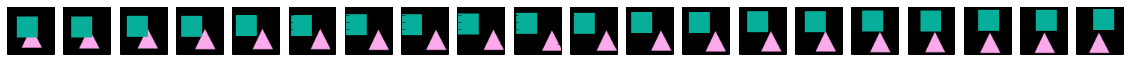

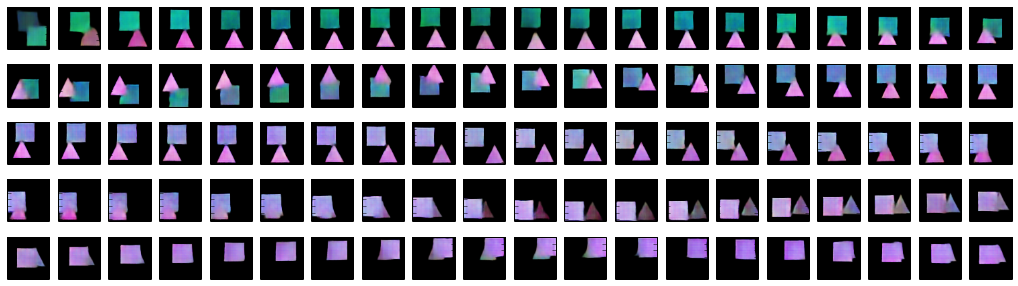

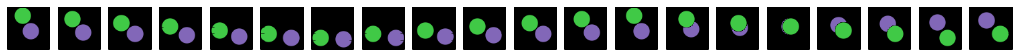

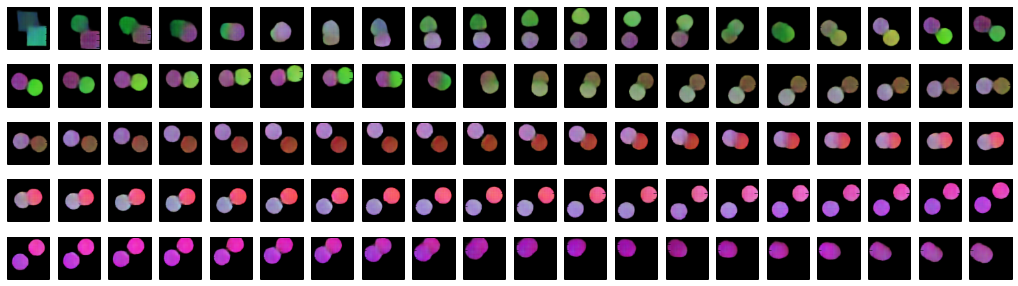

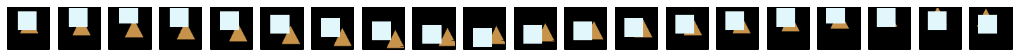

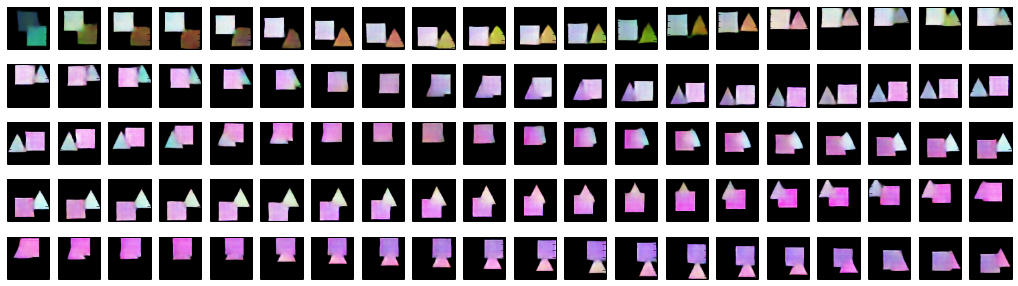

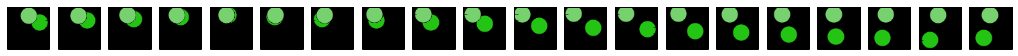

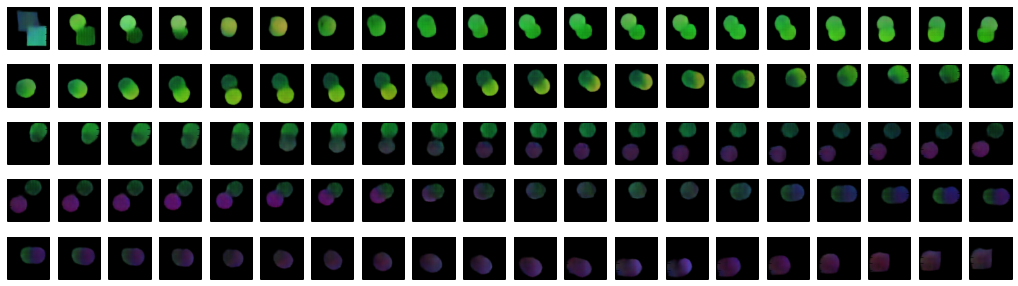

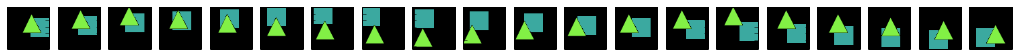

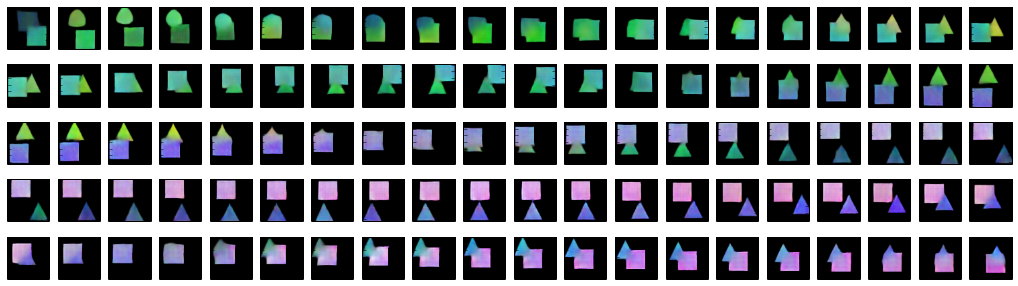

In [5]:
y_prediction = sess.run(y_hat_out, feed_dict={x_: x_tr[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(1,6,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(tr_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(100):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

(50, 200, 64, 64, 3)


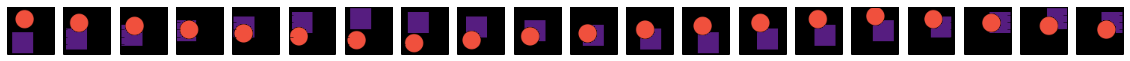

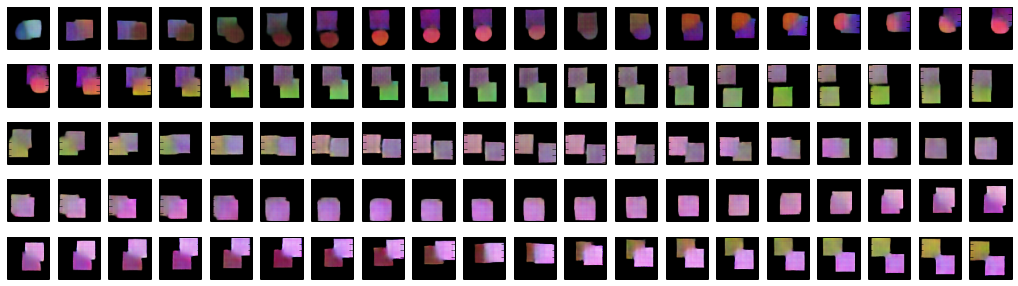

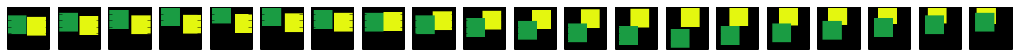

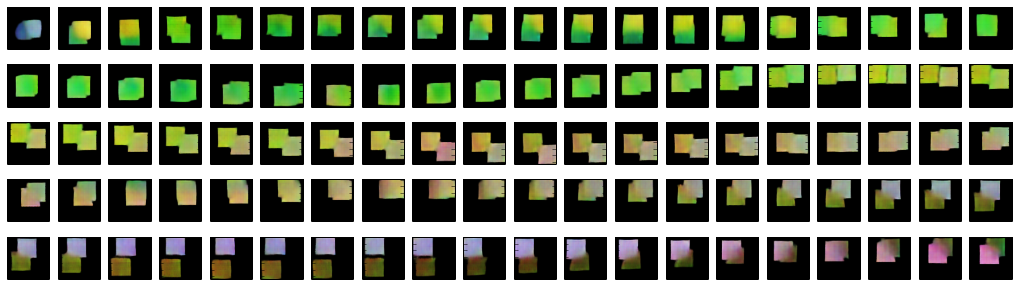

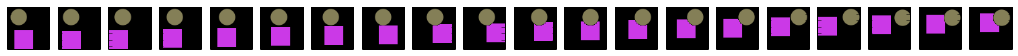

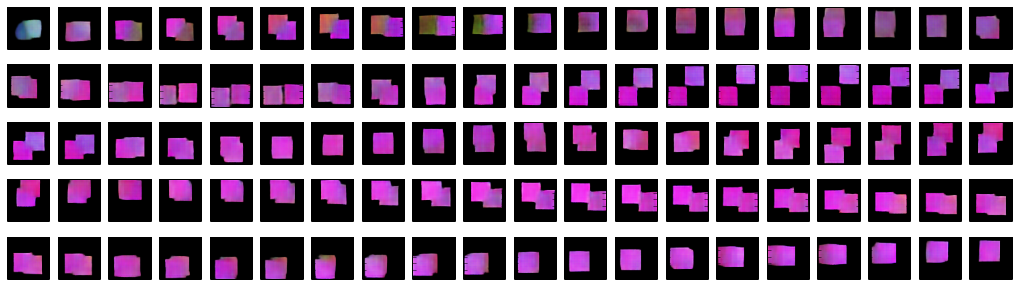

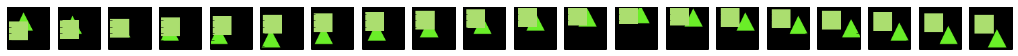

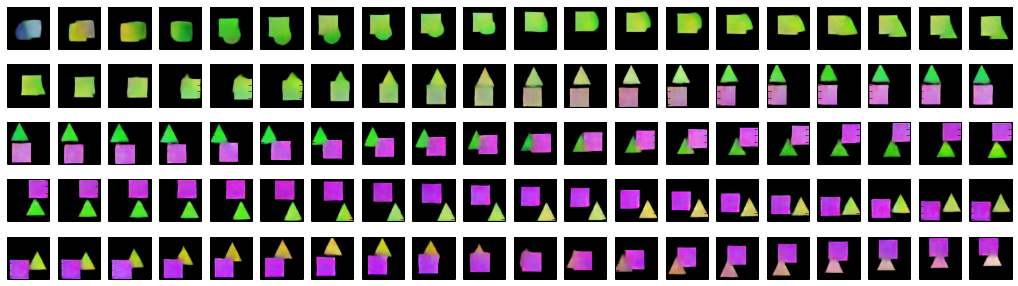

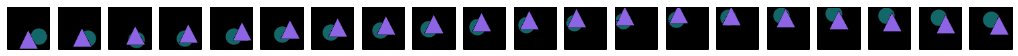

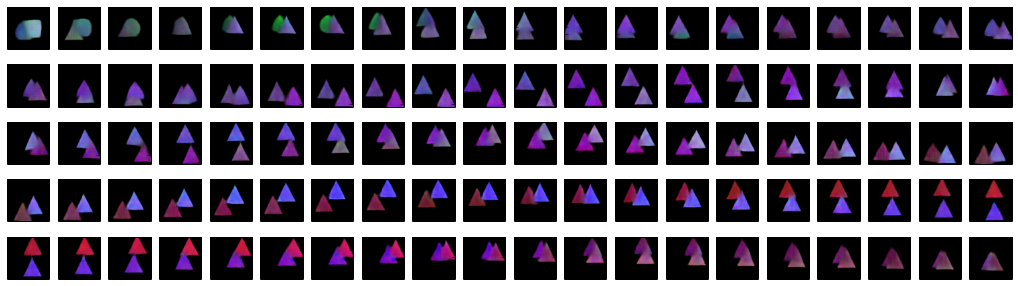

In [6]:
y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
#np.save("ms-vrnn-2-shape.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(1,6,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(100):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Out of domain inputs (3 shapes)

(100, 19, 64, 64, 3) (100, 19, 64, 64, 3)
(50, 200, 64, 64, 3)


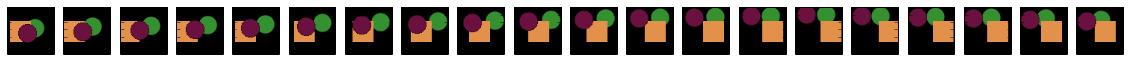

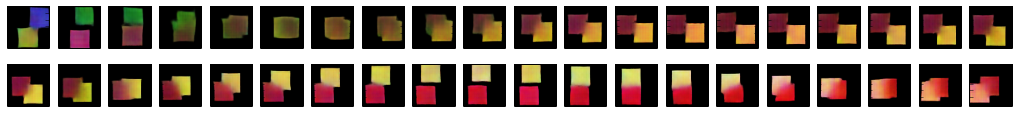

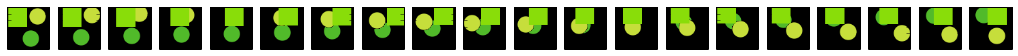

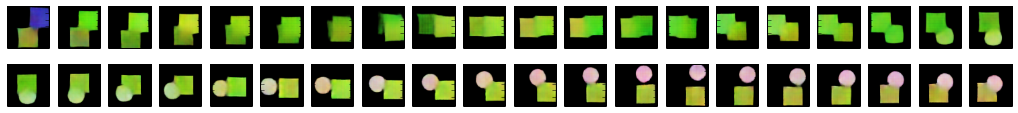

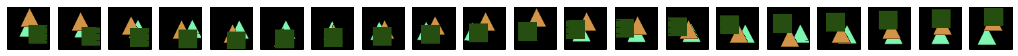

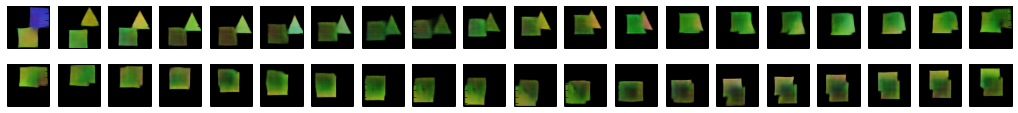

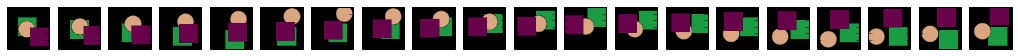

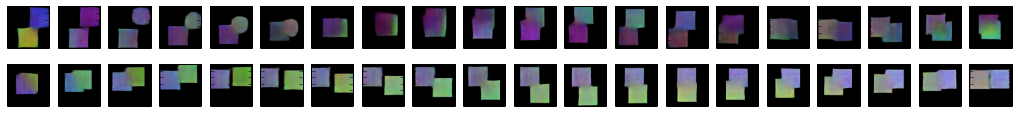

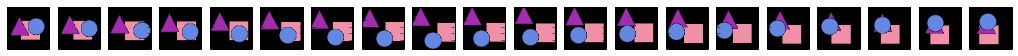

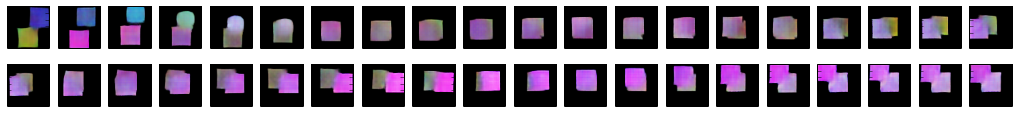

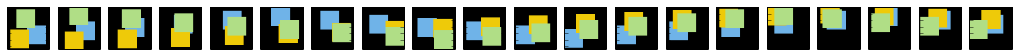

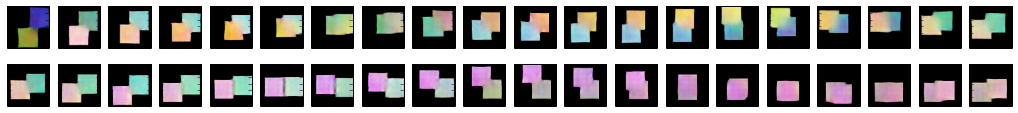

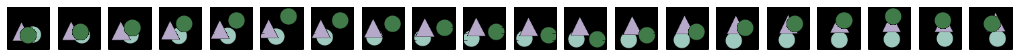

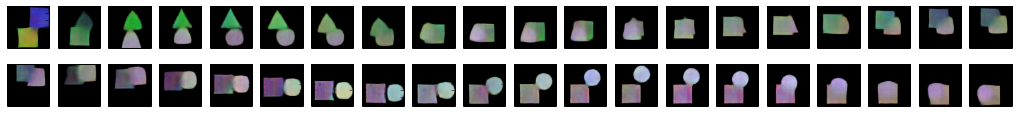

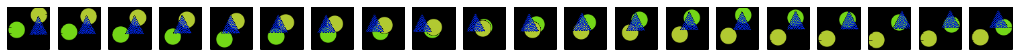

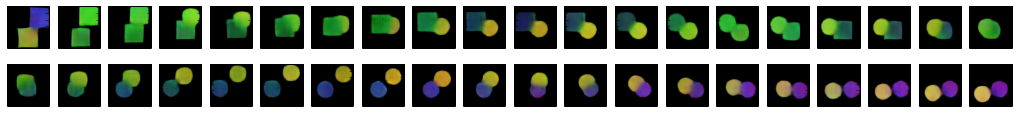

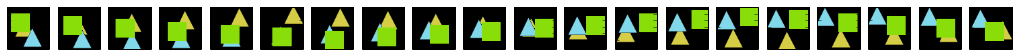

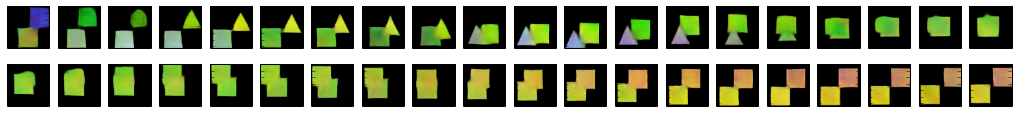

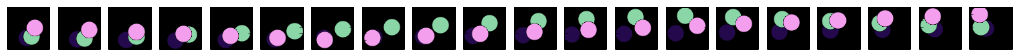

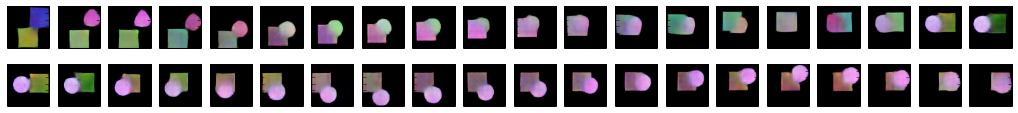

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../../datasets/shapes-3-images.npy" )

x_te = data[:,in_timesteps]
y_te = data[:,out_timesteps]
te_set = data

print np.shape(x_te), np.shape(y_te)

y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
np.save("ms-vrnn-3-shape.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(0,10,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(40):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Out of domain inputs (1 shapes)

(100, 19, 64, 64, 3) (100, 19, 64, 64, 3)
(50, 200, 64, 64, 3)


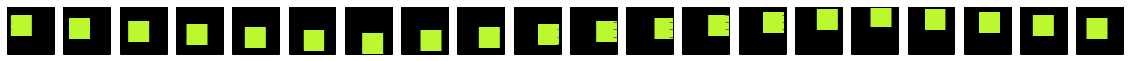

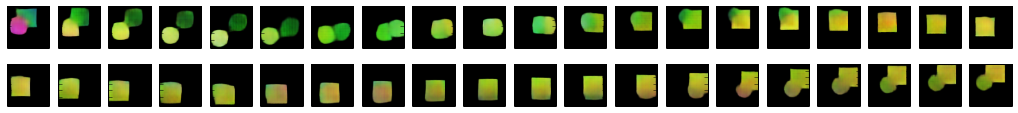

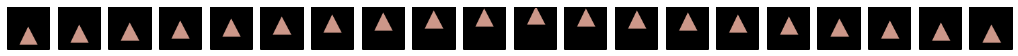

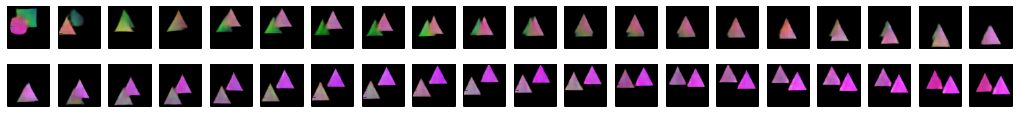

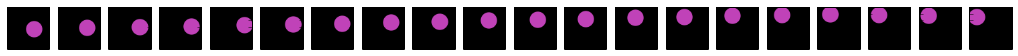

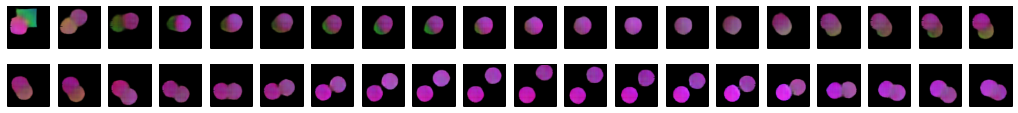

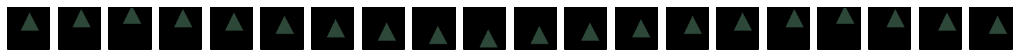

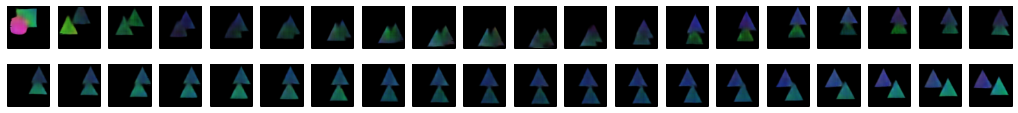

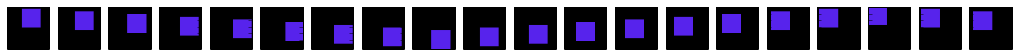

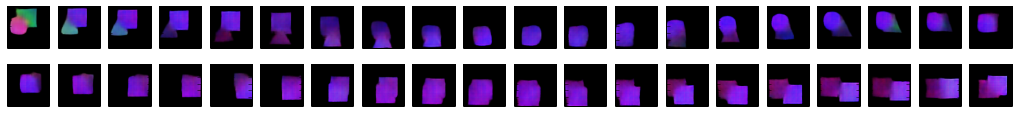

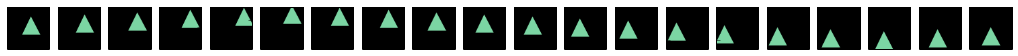

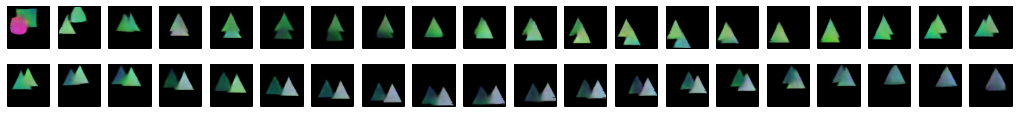

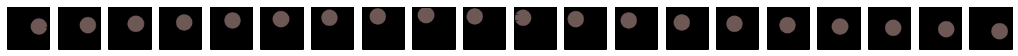

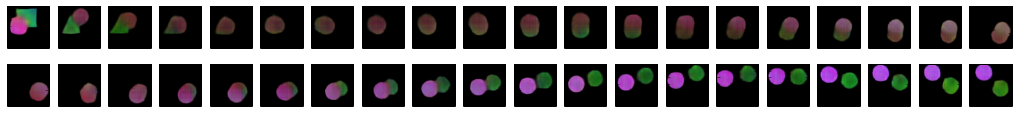

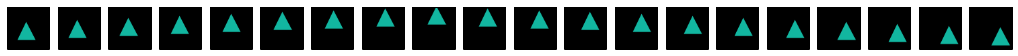

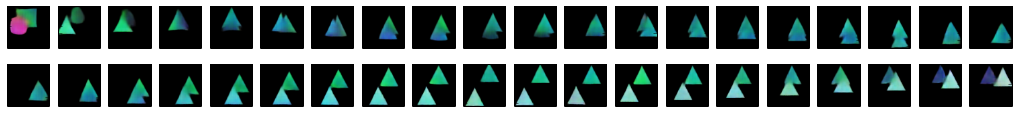

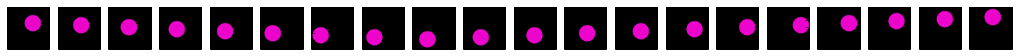

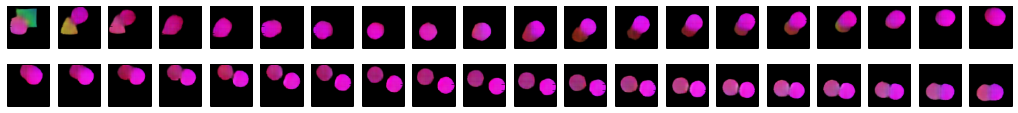

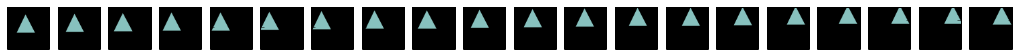

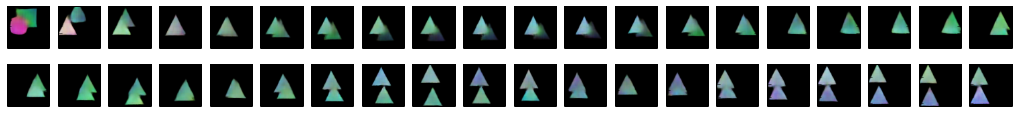

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../../datasets/shapes-1-images.npy" )

x_te = data[:,in_timesteps]
y_te = data[:,out_timesteps]
te_set = data

print np.shape(x_te), np.shape(y_te)

y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)

np.save("ms-vrnn-1-shape.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(10,20,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(40):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Latent activity analysis

(100, 19, 256)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


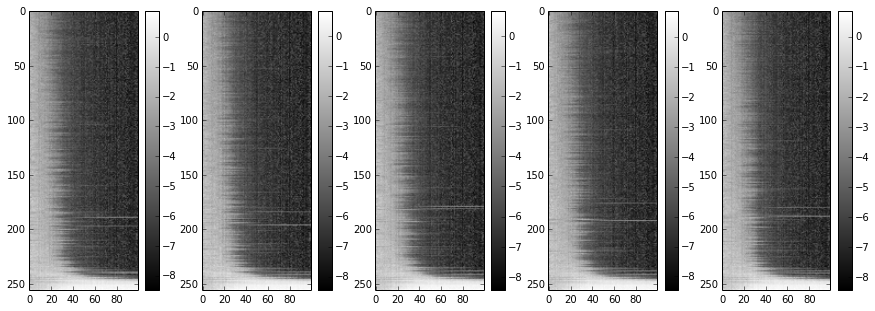

In [10]:
kl_tr_all = np.load("kl_tr_all.npy")
kl_te_all = np.load("kl_te_all.npy")

print np.shape(kl_tr_all)
rcParams['figure.figsize'] = 15,5

plt.figure()

for i in range(5):
    plt.subplot(1,5,i)
    t10 = np.transpose(kl_tr_all[:,i+10,:])
    t10sum = np.sum(t10, axis=1)
    t10idx = t10sum.argsort()
    t10 = np.take(t10, t10idx, axis=0)
    plt.imshow(np.log(t10), cmap='gray')
    plt.colorbar()

In [ ]:
print np.shape(kl_tr_all)
rcParams['figure.figsize'] = 15,5

plt.figure()

for i in range(5):
    plt.subplot(1,5,i)
    t10 = np.transpose(kl_tr_all[:,i+10,:])
    t10sum = np.sum(t10, axis=1)
    t10idx = t10sum.argsort()
    t10 = np.take(t10, t10idx, axis=0)
    plt.imshow(np.log(t10), cmap='gray')
    plt.colorbar()


# Latent space analysis

In [ ]:
timestep = 5

log_dir = os.path.join(os.getcwd(), "tensorboard")
path_to_sprites =  os.path.join(log_dir,'sprite.png')

# get mu
mu_list = []
for i in range(0,1):
    #mu_list = sess.run(phi_prior_mu, feed_dict={x_: x_te[batch_size*i:batch_size+batch_size*i,in_timesteps,:,:,:]})
    mu_list.append(sess.run(phi_prior_mu, feed_dict={x_: x_tr[batch_size*i:batch_size+batch_size*i,in_timesteps,:,:,:]}))
    #mu_list.append(sess.run(phi_prior_mu, feed_dict={x_: x_tr[0:50,in_timesteps,:,:,:]}))

mu = np.array(mu_list)
print np.shape(mu)
mu = np.reshape(mu,newshape=[50,19,256])
print np.shape(mu)

mu1 = mu[:,5,:]
mu2 = mu[:,8,:]
mu = np.concatenate((mu1,mu2),axis=0)
print np.shape(mu)

In [ ]:
# set embedding variables
#embedding_var = tf.Variable(mu[:,timestep,:], name="mu_0")
embedding_var = tf.Variable(mu, name="mu_0")

# initialize config projector
config = projector.ProjectorConfig()

# add embeddings
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.sprite.image_path = path_to_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([64,64])

# visualize embeddings
projector.visualize_embeddings(tf.summary.FileWriter(log_dir), config)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(log_dir, "model.ckpt"), 1)

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots, 3))
    
    print img_h * n_plots
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

#def vector_to_matrix_mnist(mnist_digits):
#    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
#    return np.reshape(mnist_digits,(-1,28,28))

#def invert_grayscale(mnist_digits):
#    """ Makes black white, and white black """
#    return 1-mnist_digits

to_visualise = x_tr[0:100,timestep,:,:,:]
print np.shape(to_visualise)
sprite_image = create_sprite_image(to_visualise)

print np.shape(sprite_image)

plt.imsave(path_to_sprites,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')


In [ ]:
phi = []
for x_te_batch, y_te_batch in batch_data(x_te, y_te, batch_size=batch_size):
    phi_temp = sess.run(phi_prior_mu, feed_dict={x_: x_te_batch})   
    phi.append(phi_temp)
    
phi_old = phi
phi = np.reshape(phi, newshape=(1000,19,256))

In [ ]:
u_ = tf.placeholder("float", shape= (None, 20, 256))

y_hat_list = []
y_hathat_list = []
phi_prior_out_mu_list = []
temp = []

phi_x_out = encoder(tf.divide(x=x_[:,0,:,:,:],y=255.0))
    
phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)
phi_prior_out_mu_list.append(phi_prior_out_mu)
        
phi_z_out = phi_z(z)

phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
y_hat = decoder(phi_dec_out)
y_hat_list.append(y_hat)
   
lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)
        
for i in range(1,len(in_timesteps)):
    
    phi_x_out = encoder(tf.divide(x=x_[:,i,:,:,:],y=255.0))

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)
    phi_prior_out_mu_list.append(phi_prior_out_mu)

    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
                
    for j in range(20):
        temp.append(decoder(phi_dec(tf.concat(values=(lstm_state[1], phi_z(u_[:,j,:])), axis=1))))
    y_hathat_list.append(temp)
    temp = []

    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)
    
for i in range(len(in_timesteps),60):
    
    phi_x_out = encoder(y_hat)

    phi_prior_out_mu, phi_prior_out_sigma = phi_prior(lstm_state[1])
    z = phi_prior_out_mu + phi_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)
    phi_prior_out_mu_list.append(phi_prior_out_mu)

    phi_z_out = phi_z(z)

    phi_dec_out = phi_dec(tf.concat(values=(lstm_state[1], phi_z_out), axis=1)) 
    y_hat = decoder(phi_dec_out)
    y_hat_list.append(y_hat)
               
#    if(i > 40):
#        for j in range(20):
#            temp.append(decoder(phi_dec(tf.concat(values=(lstm_state[1], phi_z(u_[:,j,:])), axis=1))))
#        y_hathat_list.append(temp)
#        temp = []

    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(phi_x_out, phi_z_out), axis=1), state = lstm_state)

y_hat_out = tf.transpose(tf.stack(y_hat_list), [1, 0, 2, 3, 4])
y_hathat_out = tf.transpose(tf.stack(y_hathat_list), [2, 0, 1, 3, 4, 5])
phi_prior_mu = tf.transpose(tf.stack(phi_prior_out_mu_list), [1, 0, 2])

# (18, 20, 100, 64, 64, 1)


In [ ]:
prior_mu_batch = sess.run(phi_prior_mu, feed_dict={x_: x_tr[0:batch_size,in_timesteps,:,:,:]})

In [ ]:
print prior_mu_batch[REFERENCE,TIMESTEP][1]
print prior_mu_batch[5,TIMESTEP][1]
print np.shape(lin_list)

print lin_list[0,0,0]
print lin_list[0,1,0]
print lin_list[0,2,0]
print lin_list[0,3,0]
print lin_list[0,4,0]
print lin_list[0,5,0]

In [ ]:
print np.shape(a), np.shape(b)

In [ ]:
## # select image and timestep
TIMESTEP = 5
REFERENCE = 2
END = 8

a = prior_mu_batch[REFERENCE,TIMESTEP]
b = prior_mu_batch[END,TIMESTEP]

lin_list = []
for i in range(np.shape(a)[0]):
    lin_list.append(np.linspace(a[i],b[i]*30,20))
lin_list = np.transpose(lin_list)
lin_list = np.repeat(lin_list[np.newaxis,:,:], 50, axis=0)

# FEED PRIOR IN

y_prediction, y_hope = sess.run([y_hat_out, y_hathat_out], feed_dict={u_: lin_list, x_: x_tr[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
print np.shape(y_hope)

# Show results
rcParams['figure.figsize'] = 20,5

print "reference point"
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(tr_set[END,i,:,:])

print "start point - ground truth"
# ground truth
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(tr_set[REFERENCE,i,:,:])

print "start point - predictions"
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1) 
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(y_prediction[REFERENCE,i,:,:])

print "latent space"
for sequence in range(0,18,1):

    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_hope[REFERENCE,sequence,i,:,:]) # 19   (100, 18, 20, 64, 64, 1)

In [ ]:
## # select image and timestep
TIMESTEP = 5
REFERENCE = 2
END = 15

a = prior_mu_batch[REFERENCE,TIMESTEP]
b = prior_mu_batch[END,TIMESTEP]

lin_list = []
for i in range(np.shape(a)[0]):
    lin_list.append(np.linspace(a[i],b[i]*10,20))
lin_list = np.transpose(lin_list)
lin_list = np.repeat(lin_list[np.newaxis,:,:], 50, axis=0)

# FEED PRIOR IN

y_prediction, y_hope = sess.run([y_hat_out, y_hathat_out], feed_dict={u_: lin_list, x_: x_tr[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
print np.shape(y_hope)

# Show results
rcParams['figure.figsize'] = 20,5

print "reference point"
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(tr_set[END,i,:,:])

print "start point - ground truth"
# ground truth
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(tr_set[REFERENCE,i,:,:])

print "start point - predictions"
fig = plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1) 
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(y_prediction[REFERENCE,i,:,:])

print "latent space"
for sequence in range(0,18,1):

    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_hope[REFERENCE,sequence,i,:,:]) # 19   (100, 18, 20, 64, 64, 1)